# Installations 
install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` to achieve much faster loading. The other packages are required to run the notebook.

In [1]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate
!pip3 install labml
!pip3 install labml-nn
!pip3 install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5

In [2]:
# clone the repository
!git clone https://github.com/kk-digital/kcg-ml-sd1p4.git
# move to the repo
%cd kcg-ml-sd1p4/

Cloning into 'kcg-ml-sd1p4'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 76 (delta 26), reused 38 (delta 7), pack-reused 0
Unpacking objects: 100% (76/76), 1.28 MiB | 10.68 MiB/s, done.
/content/kcg-ml-sd1p4


# Text to Image

In [3]:
# download model weights
!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt

--2023-04-02 12:05:15--  https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt
Resolving huggingface.co (huggingface.co)... 35.173.225.216, 54.88.195.164, 54.82.45.103, ...
Connecting to huggingface.co (huggingface.co)|35.173.225.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/4c/37/4c372b4ebb57bbd02e68413d4951aa326d4b3cfb6e62db989e529c6d4b26fb21/fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sd-v1-4.ckpt%3B+filename%3D%22sd-v1-4.ckpt%22%3B&Expires=1680693316&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzRjLzM3LzRjMzcyYjRlYmI1N2JiZDAyZTY4NDEzZDQ5NTFhYTMyNmQ0YjNjZmI2ZTYyZGI5ODllNTI5YzZkNGIyNmZiMjEvZmU0ZWZmZjFlMTc0YzYyNzI1NmU0NGVjMjk5MWJhMjc5YjM4MTZlMzY0YjQ5ZjliZTJhYmMwYjNmZjNmODU1Nj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3

In [4]:
"""
---
title: Generate images using stable diffusion with a prompt
summary: >
 Generate images using stable diffusion with a prompt
---

# Generate images using [stable diffusion](../index.html) with a prompt
"""

import os
from pathlib import Path

import torch

from labml import lab, monit
from stable_diffusion.latent_diffusion import LatentDiffusion
from stable_diffusion.sampler.ddim import DDIMSampler
from stable_diffusion.sampler.ddpm import DDPMSampler
from stable_diffusion.util import load_model, save_images, set_seed


class Txt2Img:
    """
    ### Text to image class
    """
    model: LatentDiffusion

    def __init__(self, *,
                 checkpoint_path: Path,
                 sampler_name: str,
                 n_steps: int = 50,
                 ddim_eta: float = 0.0,
                 ):
        """
        :param checkpoint_path: is the path of the checkpoint
        :param sampler_name: is the name of the [sampler](../sampler/index.html)
        :param n_steps: is the number of sampling steps
        :param ddim_eta: is the [DDIM sampling](../sampler/ddim.html) $\eta$ constant
        """
        # Load [latent diffusion model](../latent_diffusion.html)
        self.model = load_model(checkpoint_path)
        # Get device
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        # Move the model to device
        self.model.to(self.device)

        # Initialize [sampler](../sampler/index.html)
        if sampler_name == 'ddim':
            self.sampler = DDIMSampler(self.model,
                                       n_steps=n_steps,
                                       ddim_eta=ddim_eta)
        elif sampler_name == 'ddpm':
            self.sampler = DDPMSampler(self.model)

    @torch.no_grad()
    def __call__(self, *,
                 dest_path: str,
                 batch_size: int = 3,
                 prompt: str,
                 h: int = 512, w: int = 512,
                 uncond_scale: float = 7.5,
                 ):
        """
        :param dest_path: is the path to store the generated images
        :param batch_size: is the number of images to generate in a batch
        :param prompt: is the prompt to generate images with
        :param h: is the height of the image
        :param w: is the width of the image
        :param uncond_scale: is the unconditional guidance scale $s$. This is used for
            $\epsilon_\theta(x_t, c) = s\epsilon_\text{cond}(x_t, c) + (s - 1)\epsilon_\text{cond}(x_t, c_u)$
        """
        # Number of channels in the image
        c = 4
        # Image to latent space resolution reduction
        f = 8

        # Make a batch of prompts
        prompts = batch_size * [prompt]

        # AMP auto casting
        with torch.cuda.amp.autocast():
            # In unconditional scaling is not $1$ get the embeddings for empty prompts (no conditioning).
            if uncond_scale != 1.0:
                un_cond = self.model.get_text_conditioning(batch_size * [""])
            else:
                un_cond = None
            # Get the prompt embeddings
            cond = self.model.get_text_conditioning(prompts)
            # [Sample in the latent space](../sampler/index.html).
            # `x` will be of shape `[batch_size, c, h / f, w / f]`
            x = self.sampler.sample(cond=cond,
                                    shape=[batch_size, c, h // f, w // f],
                                    uncond_scale=uncond_scale,
                                    uncond_cond=un_cond)
            # Decode the image from the [autoencoder](../model/autoencoder.html)
            images = self.model.autoencoder_decode(x)

        # Save images
        save_images(images, dest_path, 'txt_')

    # functions for pipeline
    @torch.no_grad()
    def generate_text_embeddings(self, prompt, batch_size=4, uncond_scale=7.5):
        """
        :param prompt: is the prompt to generate images with
        """
        # Make a batch of prompts
        prompts = batch_size * [prompt]

        # AMP auto casting
        with torch.cuda.amp.autocast():
            # In unconditional scaling is not $1$ get the embeddings for empty prompts (no conditioning).
            if uncond_scale != 1.0:
                un_cond = self.model.get_text_conditioning(batch_size * [""])
            else:
                un_cond = None
            # Get the prompt embeddings
            cond = self.model.get_text_conditioning(prompts)
        
        # return the embeddings
        return cond, un_cond
    
    @torch.no_grad()
    def generate_latent_space(self, cond, un_cond, batch_size=4, uncond_scale=7.5, h=512, w=512):
        """
        :param prompt: is the prompt to generate images with
        """
        # Number of channels in the image
        c = 4
        # Image to latent space resolution reduction
        f = 8

        # AMP auto casting
        with torch.cuda.amp.autocast():
            # [Sample in the latent space](../sampler/index.html).
            # `x` will be of shape `[batch_size, c, h / f, w / f]`
            x = self.sampler.sample(cond=cond,
                                    shape=[batch_size, c, h // f, w // f],
                                    uncond_scale=uncond_scale,
                                    uncond_cond=un_cond)
        
        # return the embeddings
        return x
    
    @torch.no_grad()
    def generate_image(self, x):
        """
        :param prompt: is the prompt to generate images with
        """
        # AMP auto casting
        with torch.cuda.amp.autocast():
            # Decode the image from the [autoencoder](../model/autoencoder.html)
            image = self.model.autoencoder_decode(x)
        
        # return the embeddings
        return image


In [5]:
# create an instance of the class
sampler_name = 'ddim'
steps = 50
batch_size = 4
scale = 7.5
txt2img = Txt2Img(checkpoint_path='sd-v1-4.ckpt',
                      sampler_name=sampler_name,
                      n_steps=steps)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.20.layer_norm1.bias', 'vision_model.encoder.layers.18.layer_norm1.weight', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.

In [6]:
prompt = "a photograph of an astronaut riding a horse"

# Generate Text Embeddings

In [7]:
# function to get the embeddings
def get_embeddings(prompt, batch_size=1, uncond_scale=7.5):
    # get the embeddings
    cond, un_cond = txt2img.generate_text_embeddings(prompt=prompt, batch_size=batch_size, uncond_scale=uncond_scale)
    # return the embeddings
    return cond, un_cond

In [8]:
cond, un_cond = get_embeddings(prompt=prompt, batch_size=batch_size, uncond_scale=scale)

# Generate Latents

In [9]:
# function to get the latent space
def get_latent_space(cond, un_cond, batch_size=4, uncond_scale=7.5, h=512, w=512):
    # get the embeddings
    x = txt2img.generate_latent_space(cond=cond, un_cond=un_cond, batch_size=batch_size, uncond_scale=uncond_scale, h=h, w=w)
    # return the embeddings
    return x

In [10]:
x = get_latent_space(cond=cond, un_cond=un_cond, batch_size=batch_size, uncond_scale=scale, h=512, w=512)

# Decoding Latents

In [11]:
# function to get the image
def get_image(x):
    image = txt2img.generate_image(x)
    return image

In [12]:
image = get_image(x)

# Save the Image

In [13]:
# function to save the image
def save_image(image, dest_path):
    # save the image
    save_images(image, dest_path, 'txt_')


In [14]:
save_image(image, dest_path='./output_images')

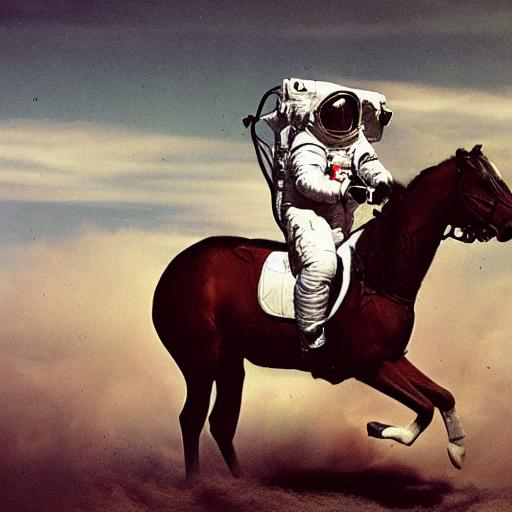

In [17]:
# show the first image
from PIL import Image
Image.open('./output_images/txt_00000.jpeg')